In [108]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [109]:
import tensorflow as tf

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [111]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

In [113]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [114]:
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)
img_labels_df = img_labels_df[img_labels_df['split_diagnoses'].apply(lambda x: len(x) == 1)]
no_finding_df = img_labels_df[img_labels_df['diagnosis'] == 'No Finding']
no_finding_df.shape
no_findings_rows_to_drop = no_finding_df.sample(frac=0.85).index
img_labels_df = img_labels_df.drop(no_findings_rows_to_drop)

In [115]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (40017, 27)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Mass,Fibrosis,Cardiomegaly,Pneumonia,Atelectasis,Consolidation,Emphysema,Effusion,Pneumothorax,Nodule
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,False,False,True,False,False,False,False,False,False,False
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,...,False,False,False,False,False,False,False,False,False,False
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,...,False,False,False,False,False,False,False,False,False,False
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
10,00000003_007.png,Hernia,6,3,80,F,PA,2582,2905,0.143,...,False,False,False,False,False,False,False,False,False,False
11,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,False,False
23,00000008_000.png,Cardiomegaly,0,8,68,F,PA,2048,2500,0.171,...,False,False,True,False,False,False,False,False,False,False


In [116]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)

In [117]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 34014
Validation Size: 6003


In [118]:
training_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Cardiomegaly,Pneumonia,Atelectasis,Consolidation,Emphysema,Effusion,Pneumothorax,Nodule,vectorized_diagnoses,img_path
51258,00012945_000.png,Infiltration,0,12945,57,F,PA,2738,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00012945_000.png
97479,00025722_002.png,No Finding,2,25722,53,F,PA,2798,2613,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00025722_002.png
85530,00021086_004.png,Effusion,4,21086,62,M,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00021086_004.png
42493,00010936_015.png,Pneumothorax,11,10936,38,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00010936_015.png
74144,00018233_004.png,Cardiomegaly,12,18233,46,F,PA,2502,2637,0.143,...,True,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00018233_004.png
58456,00014454_002.png,Nodule,2,14454,38,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014454_002.png
77256,00018972_049.png,Edema,49,18972,52,F,AP,2500,2048,0.168,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00018972_049.png
79291,00019472_004.png,No Finding,4,19472,36,M,PA,2870,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00019472_004.png
74741,00018360_003.png,Effusion,3,18360,62,M,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00018360_003.png
90645,00022572_026.png,Pneumothorax,27,22572,48,M,AP,3056,2544,0.139,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00022572_026.png


In [119]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Cardiomegaly,Pneumonia,Atelectasis,Consolidation,Emphysema,Effusion,Pneumothorax,Nodule,vectorized_diagnoses,img_path
71669,00017651_003.png,Effusion,3,17651,73,M,PA,2992,2991,0.143,...,False,False,False,False,False,True,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00017651_003.png
90921,00022651_022.png,Atelectasis,23,22651,20,M,PA,2992,2991,0.143,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00022651_022.png
21100,00005641_001.png,Cardiomegaly,1,5641,30,F,AP,2500,2048,0.168,...,True,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",./data/images/00005641_001.png
69386,00017124_007.png,Infiltration,7,17124,16,M,PA,2842,2741,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00017124_007.png
85427,00021048_000.png,Fibrosis,0,21048,63,F,PA,2706,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",./data/images/00021048_000.png
99471,00026325_003.png,Atelectasis,3,26325,41,M,PA,2992,2991,0.143,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00026325_003.png
77363,00019003_000.png,Infiltration,2,19003,67,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00019003_000.png
57584,00014265_023.png,Mass,22,14265,24,M,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",./data/images/00014265_023.png
59469,00014696_000.png,Infiltration,0,14696,51,F,PA,2978,2417,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00014696_000.png
72660,00017912_000.png,Infiltration,0,17912,55,F,PA,2992,2991,0.143,...,False,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",./data/images/00017912_000.png


In [120]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [121]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 32)

Found 34014 validated image filenames belonging to 15 classes.


In [122]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                            directory=None,
                            x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                            class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                            color_mode = 'grayscale',
                            batch_size = 256)

Found 6003 validated image filenames belonging to 15 classes.


In [123]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 34014 validated image filenames belonging to 15 classes.


In [124]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'grayscale',
                            batch_size = 1024))

Found 6003 validated image filenames belonging to 15 classes.


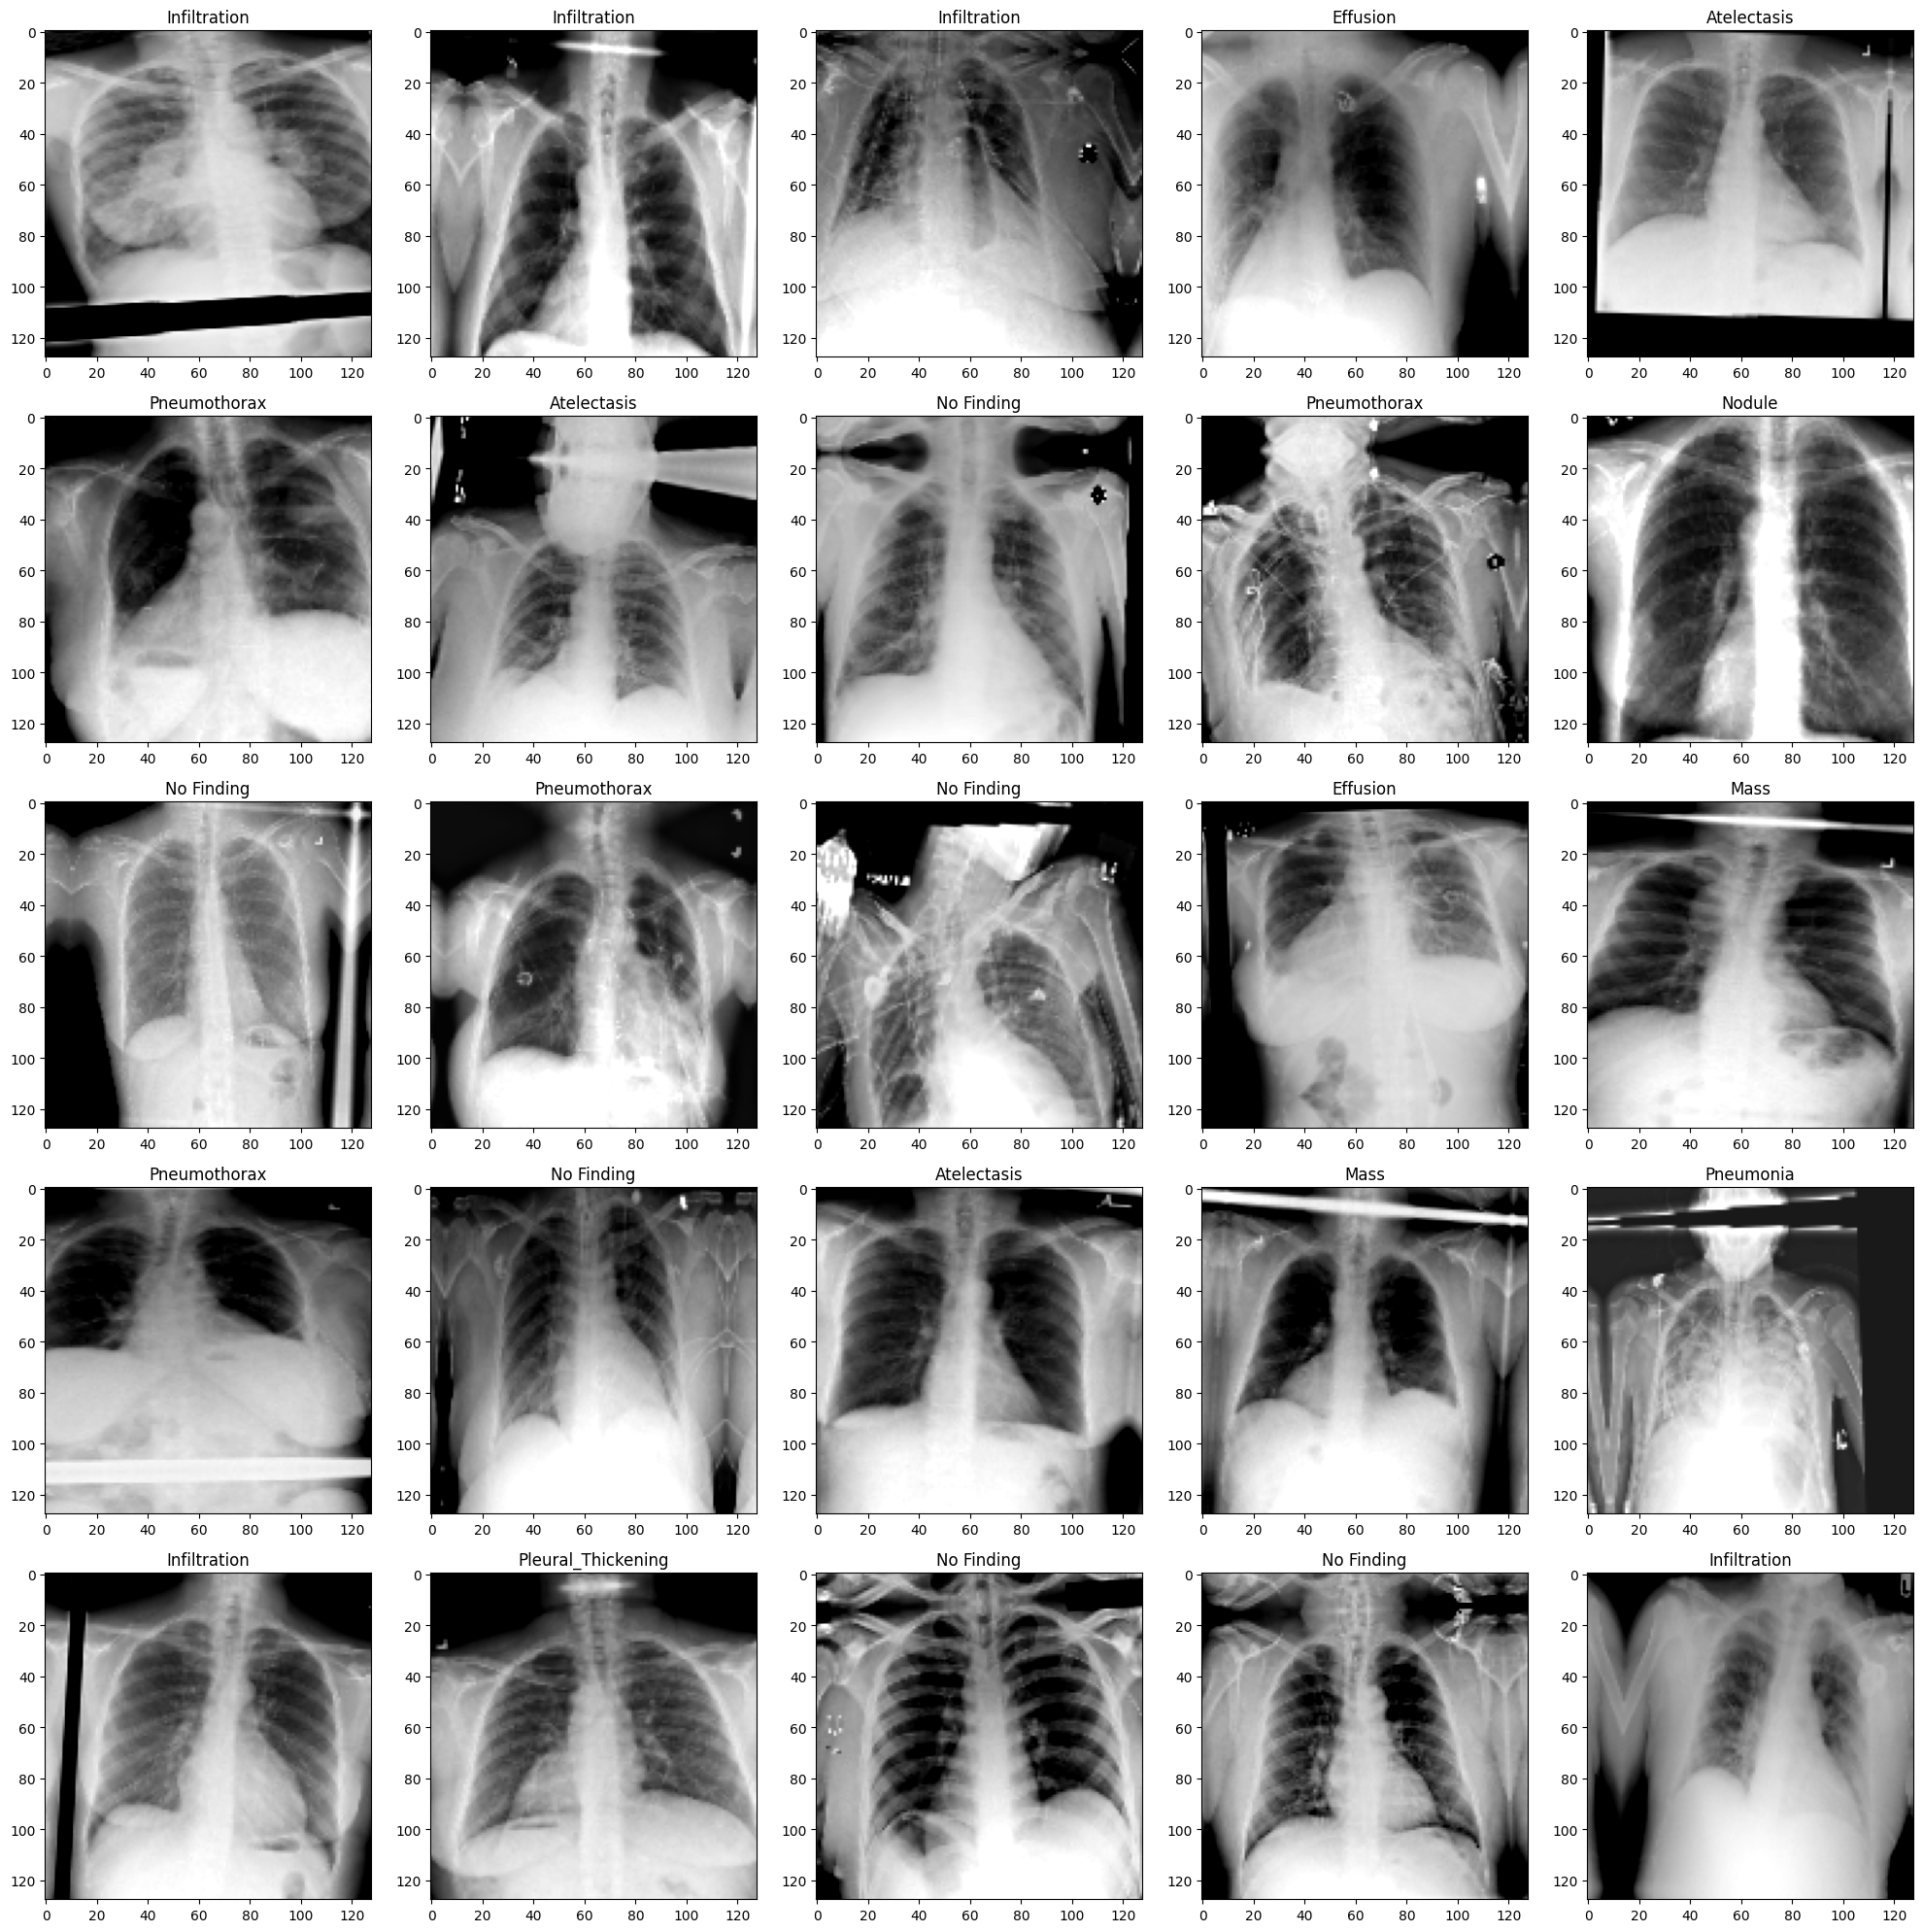

In [125]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [126]:
mnet_model = MobileNet(input_shape = tr_x.shape[1:], 
                                 include_top = False, weights = None)

MULTI_DIAGNOSIS_MODEL_PARAMETERS = {
    "DROPOUT": 0.5,
    "DENSE": 512,
    "ACTIVATION": 'sigmoid',
    "OPTIMIZER": 'adam',
    "LOSS": 'binary_crossentropy',
    "METRICS": ['binary_accuracy', 'mae']
}

In [127]:
multi_disease_model = Sequential()
multi_disease_model.add(mnet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DENSE"]))
multi_disease_model.add(Dropout(MULTI_DIAGNOSIS_MODEL_PARAMETERS["DROPOUT"]))
multi_disease_model.add(Dense(len(all_diagnoses), activation = MULTI_DIAGNOSIS_MODEL_PARAMETERS["ACTIVATION"]))
multi_disease_model.compile(optimizer = MULTI_DIAGNOSIS_MODEL_PARAMETERS["OPTIMIZER"], loss = MULTI_DIAGNOSIS_MODEL_PARAMETERS["LOSS"],
                           metrics = MULTI_DIAGNOSIS_MODEL_PARAMETERS["METRICS"])
multi_disease_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 15)               

In [128]:
NUM_EPOCHS=1

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_multi_disease_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Training
history = multi_disease_model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

1063/1063 [==============================] - 599s 562ms/step - loss: 0.2266 - binary_accuracy: 0.9307 - mae: 0.1163 - val_loss: 0.2154 - val_binary_accuracy: 0.9333 - val_mae: 0.1084


In [132]:
test_loss, test_acc, test_mae = multi_disease_model.evaluate(v_X, v_Y, verbose=2)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}\nTest MAE: {test_mae}')

32/32 - 3s - loss: 0.2159 - binary_accuracy: 0.9333 - mae: 0.1086 - 3s/epoch - 92ms/step
Test accuracy: 0.9333329200744629
Test loss: 0.21591472625732422
Test MAE: 0.108559250831604


In [133]:
# Assuming X_test is your test set
predictions = multi_disease_model.predict(v_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(v_Y, axis=1)

32/32 [==============================] - 3s 88ms/step


In [135]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=all_diagnoses))

# Generate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

                    precision    recall  f1-score   support

            Hernia       0.00      0.00      0.00         3
      Infiltration       0.25      0.50      0.33       243
             Edema       0.00      0.00      0.00        16
        No Finding       0.31      0.31      0.31       256
Pleural_Thickening       0.00      0.00      0.00        28
              Mass       0.00      0.00      0.00        66
          Fibrosis       0.00      0.00      0.00        22
      Cardiomegaly       0.00      0.00      0.00        28
         Pneumonia       0.00      0.00      0.00         8
       Atelectasis       0.19      0.12      0.14        86
     Consolidation       0.00      0.00      0.00        23
         Emphysema       0.00      0.00      0.00        19
          Effusion       0.18      0.42      0.25        99
      Pneumothorax       0.00      0.00      0.00        55
            Nodule       0.00      0.00      0.00        72

          accuracy                    

d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projects\chest_xray8_analytics\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
multi_disease_model.save('multi_disease_model.h5')
